In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


In [3]:
X_train =pd.read_parquet("data/X_train_completo.parquet")
X_test= pd.read_parquet("data/X_test_completo.parquet")
y_train=pd.read_parquet("data/y_train.parquet")
y_test=pd.read_parquet("data/y_test.parquet")

print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

(40257, 51) (17253, 51) (40257, 1) (17253, 1)


In [7]:
y_train["target_binaria"].value_counts()

target_binaria
1    24979
0    15278
Name: count, dtype: int64

In [9]:
hiperparametros = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

optimizacion  = RandomizedSearchCV(LogisticRegression(max_iter=1000) ,
                                    hiperparametros,
                                    cv=5,
                                    n_iter=20,
                                    scoring="f1",
                                    random_state=42,
                                    n_jobs=8)
optimizacion.fit(X_train , y_train)

c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,estimator,LogisticRegre...max_iter=1000)
,param_distributions,"{'C': [0.001, 0.01, ...], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}"
,n_iter,20
,scoring,'f1'
,n_jobs,8
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [15]:
optimizacion.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 10}

## PREDICCIONES EN TEST

In [74]:
best_model = optimizacion.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred = best_model.predict(X_test)
y_pred_proba

array([0.86413611, 0.95275786, 0.19571296, ..., 0.85579179, 0.97842925,
       0.89799733], shape=(17253,))

In [27]:
optimizacion.classes_


array([0, 1])

## F1 SCORE

In [31]:
(y_pred_proba >= 0.5).sum()

np.int64(11408)

In [32]:
(y_pred == 1).sum()

np.int64(11408)

recall score: 0.9157481785914441
precision score: 0.8593969144460029
f1score: 0.8866781224563625
auc score: 0.9162967133766787
confusion matrix: 
[[4943 1604]
 [ 902 9804]]
log loss score =0.3440773970503661


<Axes: >

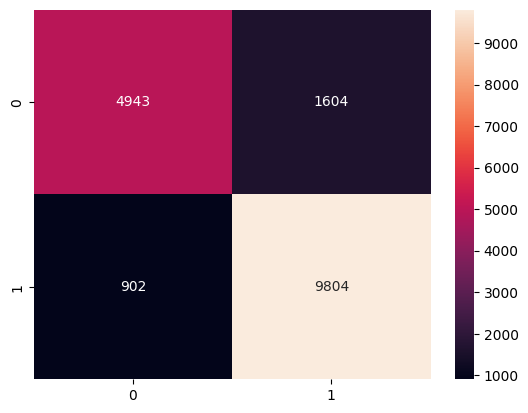

In [75]:
from sklearn.metrics import confusion_matrix , f1_score , recall_score , precision_score ,roc_auc_score,roc_curve
from sklearn.metrics import log_loss
log_loss_score=log_loss(y_test, y_pred_proba)
print(f"recall score: {recall_score(y_test , y_pred)}")
print(f"precision score: {precision_score(y_test , y_pred)}")
print(f"f1score: {f1_score(y_test , y_pred)}")
print(f"auc score: {roc_auc_score(y_test,y_pred_proba)}")
print(f"confusion matrix: \n{confusion_matrix(y_test , y_pred)}")
print(f"log loss score ={log_loss_score}")

sns.heatmap(confusion_matrix(y_test , y_pred),annot=True ,fmt='d')


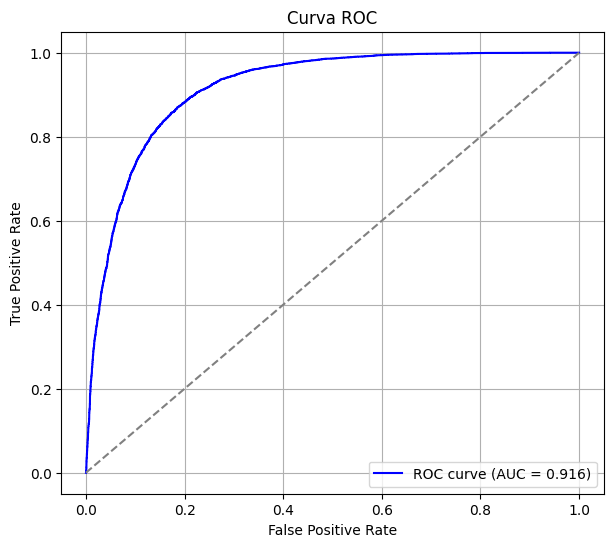

In [76]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)


plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # línea diagonal (azar)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## MEDIDA A PARTIR DE LOG LOSS

In [21]:
y_test

,target_binaria
14903,0
30335,1
52884,0
13872,0
6800,1
...,...
38717,0
21344,0
41455,1
53580,1


In [46]:
y_test == 0

,target_binaria
14903,True
30335,False
52884,True
13872,True
6800,False
...,...
38717,True
21344,True
41455,False
53580,False


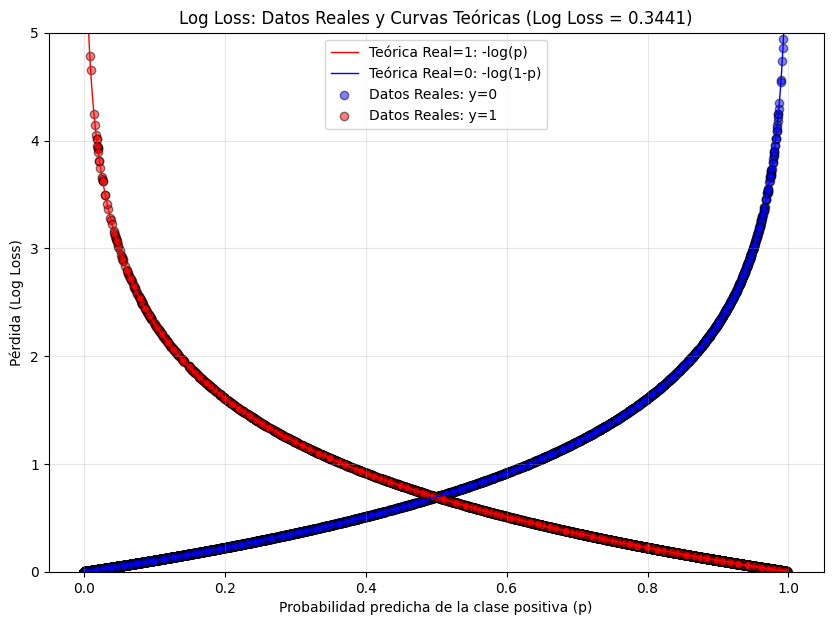

In [48]:
import matplotlib.pyplot as plt

# curvas teóricas
# p: Rango de probabilidades de 0 a 1 (evitando los bordes para el logaritmo)
p = np.linspace(1e-6, 1-1e-6, 500)
loss_y1 = -np.log(p)       # Pérdida teórica cuando la CLASE REAL es 1
loss_y0 = -np.log(1 - p)   # Pérdida teórica cuando la CLASE REAL es 0

# Pérdidas Reales del Modelo
# Extraemos las probabilidades donde la clase real es 0 (p0) y donde es 1 (p1)
p0 = y_pred_proba[y_test["target_binaria"] == 0]
p1 = y_pred_proba[y_test["target_binaria"] == 1]

# pérdida REAL para cada grupo:
# Si la clase real es 0, la pérdida es -log(1 - p)
loss0 = -np.log(np.clip(1 - p0, 1e-15, 1))
# Si la clase real es 1, la pérdida es -log(p)
loss1 = -np.log(np.clip(p1, 1e-15, 1))

plt.figure(figsize=(10,7))

# Curvas suaves (teóricas)
plt.plot(p, loss_y1, 'r-', linewidth=1, label="Teórica Real=1: -log(p)")
plt.plot(p, loss_y0, 'b-', linewidth=1, label="Teórica Real=0: -log(1-p)")

# Puntos reales (Scatter Plot)
# Puntos azules: Casos donde la CLASE REAL es 0.
# La pérdida es alta si p (prob. de ser 1) es alto.
plt.scatter(p0, loss0, color="blue", alpha=0.5, edgecolor="k", label="Datos Reales: y=0")
# Puntos rojos: Casos donde la CLASE REAL es 1.
# La pérdida es alta si p (prob. de ser 1) es bajo.
plt.scatter(p1, loss1, color="red", alpha=0.5, edgecolor="k", label="Datos Reales: y=1")

plt.xlabel("Probabilidad predicha de la clase positiva (p)")
plt.ylabel("Pérdida (Log Loss)")
plt.title(f"Log Loss: Datos Reales y Curvas Teóricas (Log Loss = {log_loss_score:.4f})")
plt.legend()
plt.ylim(0, 5)
plt.grid(alpha=0.3)
plt.show()
     


## CURVA DE COMPLEJIDAD

In [52]:
optimizacion.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 10}

In [53]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
model=LogisticRegression(solver='liblinear',penalty="l2" ,class_weight=None , C=0.01)
scores=cross_val_score(model , X_train , y_train , cv=3,scoring="roc_auc")
scores

c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chris\Data_science\Ms Data Mining UBA\2do_Cuatrimestre\AA\TPs\student-retention-ml\env_ml\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

array([0.91173216, 0.91956819, 0.91735154])

In [57]:
np.mean([1,2,6])

np.float64(3.0)

In [58]:
y_train

,target_binaria
8559,1
34963,1
53046,1
41160,1
29742,1
...,...
8053,1
13351,0
41988,1
52611,1


In [61]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import roc_auc_score
c_values=np.linspace(0.001,100,25)
cv =StratifiedKFold(n_splits=3,random_state=42 ,shuffle=True)
scores_train=[]
scores_val=[]
for i,c in enumerate(c_values):
    print(i)
    
    fold_train=[]
    fold_val=[]
    for idx_train ,idx_val in cv.split(X_train,y_train):
        X_train_i = X_train.iloc[idx_train]
        y_train_i = y_train.iloc[idx_train].values.ravel()
        X_val_i = X_train.iloc[idx_val]
        y_val_i = y_train.iloc[idx_val].values.ravel()

        model=LogisticRegression(solver='liblinear',penalty="l2" ,class_weight=None , C=c, max_iter=1000)

        model.fit(X_train_i,y_train_i)

        y_pred_train_i = model.predict_proba(X_train_i)[:,1]
        y_pred_val_i = model.predict_proba(X_val_i)[:,1]

        train_score_i=roc_auc_score(y_train_i , y_pred_train_i)
        val_score_i=roc_auc_score(y_val_i,y_pred_val_i)

        fold_train.append(train_score_i)
        fold_val.append(val_score_i)
    score_train = float(np.mean(fold_train))
    score_val = float(np.mean(fold_val))

    scores_train.append(score_train)
    scores_val.append(score_val)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


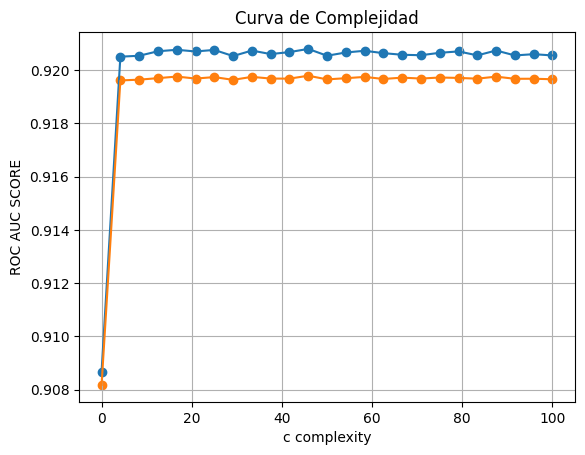

In [72]:
plt.plot(c_values,scores_train)
plt.plot(c_values,scores_val)
plt.scatter(c_values,scores_train)
plt.scatter(c_values,scores_val)
plt.grid(True)
plt.ylabel("ROC AUC SCORE")
plt.xlabel("c complexity")
plt.title("Curva de Complejidad")
plt.show()